In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.io import imread
import cv2
from skimage import color
import numpy.linalg as la
import os

In [2]:
def generate_superpixels(image_path, k):
    """
    Generates and displays superpixels for a given image using the SLIC algorithm.

    Parameters:
    - image_path: Path to the image file.
    - k: The desired number of superpixels.

    Returns:
    - A visualization of the superpixels overlaid on the original image.
    """

    # Load the image
    image = imread(image_path)

    # Apply SLIC and obtain the segment labels
    segments = slic(image, n_segments=k, compactness=10,
                    sigma=1, start_label=1)

    # Create an image showing the superpixel boundaries
    superpixels = label2rgb(segments, image, kind='avg')

    # Display the results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[1].imshow(superpixels)
    ax[1].set_title(f'Superpixels with k={k}')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

    return superpixels

# Example usage:
# generate_superpixels('path_to_your_image.jpg', k=200)


In [3]:
test_path = './logo-dataset/volkswagen/images/'


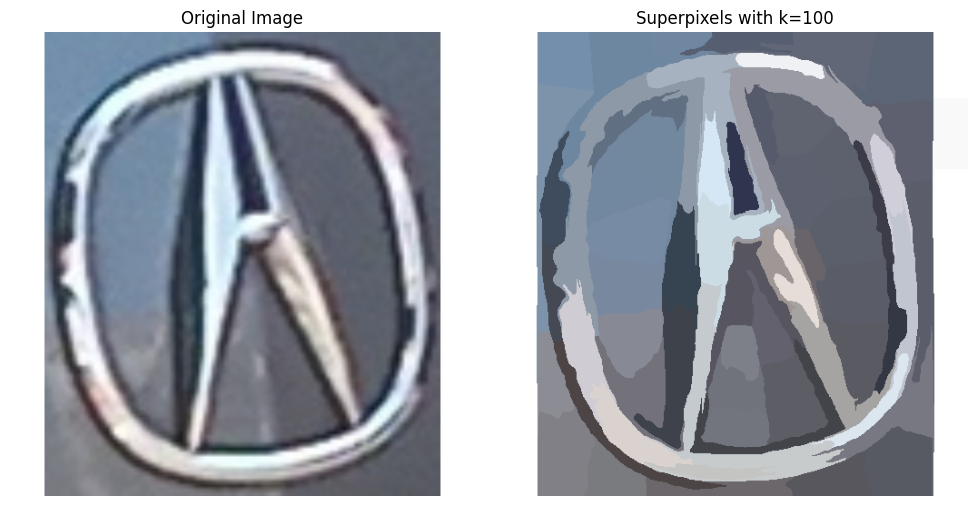

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [4]:
generate_superpixels('./logo-dataset/acura/images/0aa5a789508cd718fc4cf044352375ed54080b5e.png', 100)


In [5]:
def calculate_gradient_sobel(image):
    # Convert the image to grayscale if it is not already
    if len(image.shape) > 2:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    # Calculate the gradients using Sobel operator
    # The ddepth parameter is set to cv2.CV_64F to accommodate the result gradients.
    grad_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the gradient magnitude
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Normalize the gradient magnitude to range between 0 and 1
    gradient_magnitude_norm = cv2.normalize(
        gradient_magnitude, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)

    return gradient_magnitude_norm


In [6]:
def get_optimized_cluster_centers(image, K):
    height, width = image.shape[:2]
    S = int(np.sqrt(height * width / K))
    cluster_centers = []

    # Compute gradient using the Sobel operator
    gradient = calculate_gradient_sobel(image)

    # Loop through the image in steps of S to distribute centers
    for i in range(0, height - S, S):
        for j in range(0, width - S, S):
            center_i, center_j = i + S // 2, j + S // 2

            # Define a neighborhood around the tentative center
            neighborhood_size = S // 4
            min_pos = (center_i, center_j)
            min_gradient = gradient[center_i, center_j]

            for ni in range(max(0, center_i - neighborhood_size), min(height, center_i + neighborhood_size + 1)):
                for nj in range(max(0, center_j - neighborhood_size), min(width, center_j + neighborhood_size + 1)):
                    if gradient[ni, nj] < min_gradient:
                        min_gradient = gradient[ni, nj]
                        min_pos = (ni, nj)

            cluster_centers.append(min_pos)

    # # Visualization of the gradient magnitude
    # plt.imshow(gradient, cmap='plasma')
    # plt.colorbar()  # Show gradient magnitude scale
    # plt.scatter([c[1] for c in cluster_centers], [c[0]
    #             for c in cluster_centers], color='red')  # Mark cluster centers
    # plt.show()

    return cluster_centers, gradient


In [7]:
def slic_superpixels(image, K, m, num_iterations=6):

    # convert image to LAB
    lab_image = color.rgb2lab(image)

    height, width = image.shape[:2]

    N = height * width  # total number of pixels in the image
    A = N / K           # area of superpixel
    S = int(np.sqrt(A))  # length of each superpixel

    cluster_centers, gradient = get_optimized_cluster_centers(image, K)

    # Initialize labels and distances
    labels = -1 * np.ones(image.shape[:2], np.int32)
    distances = np.inf * np.ones(image.shape[:2], np.float64)

    spatial_scale = m/S

    # SLIC algorithm
    for _ in range(num_iterations):
        for ci, center in enumerate(cluster_centers):
            cx, cy = center
            # search in 2S range
            for i in range(max(0, cx - S), min(height, cx + S)):
                for j in range(max(0, cy - S), min(width, cy + S)):
                    
                    d_lab = math.dist(lab_image[cx, cy], lab_image[i, j])
                    d_spatial = math.dist([cx, cy], [i, j])

                    d = d_lab + spatial_scale * d_spatial

                    if d < distances[i, j]:
                        distances[i, j] = d
                        labels[i, j] = ci

        # update cluster centers
        for ci in range(len(cluster_centers)):
            members = np.where(labels == ci)
            if members[0].size > 0:
                new_center_x = np.mean(members[0])
                new_center_y = np.mean(members[1])
                cluster_centers[ci] = (
                    int(new_center_x), int(new_center_y))

    final_image = np.zeros_like(image)

    ## reconstruct final image here ##
    for ci in range(len(cluster_centers)):
        members = np.where(labels == ci)
        if members[0].size > 0:
            for channel in range(3):  # Assuming image has 3 channels
                final_image[members[0], members[1], channel] = np.mean(image[members[0], members[1], channel])

    return final_image, labels, cluster_centers, gradient

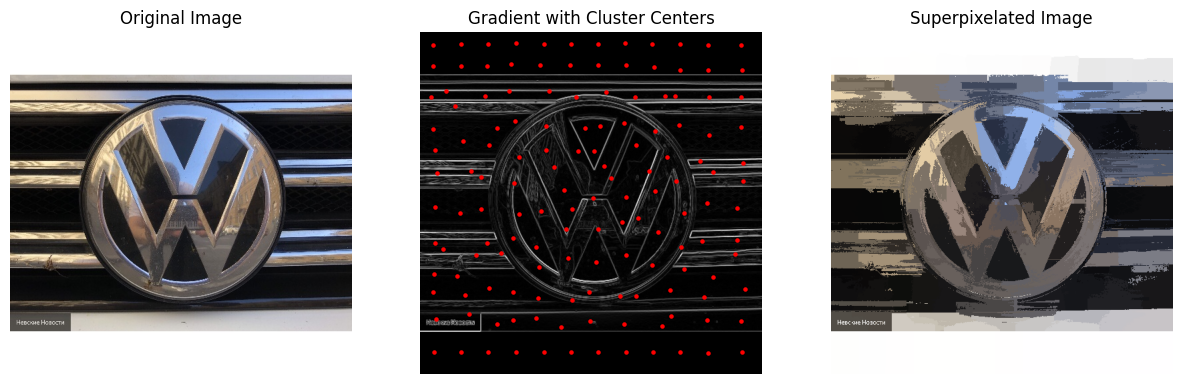

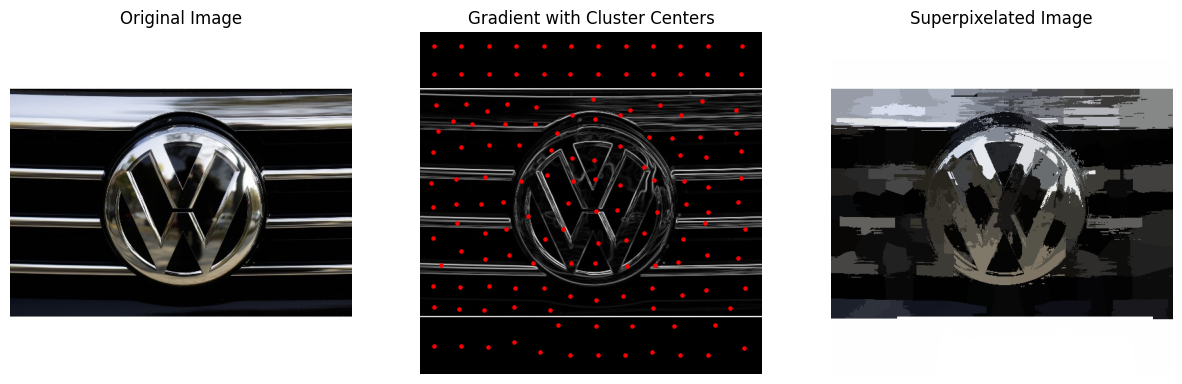

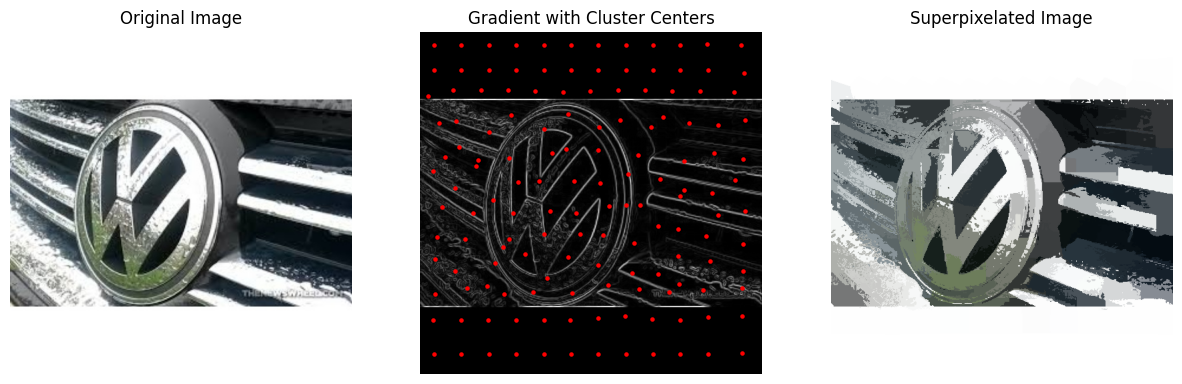

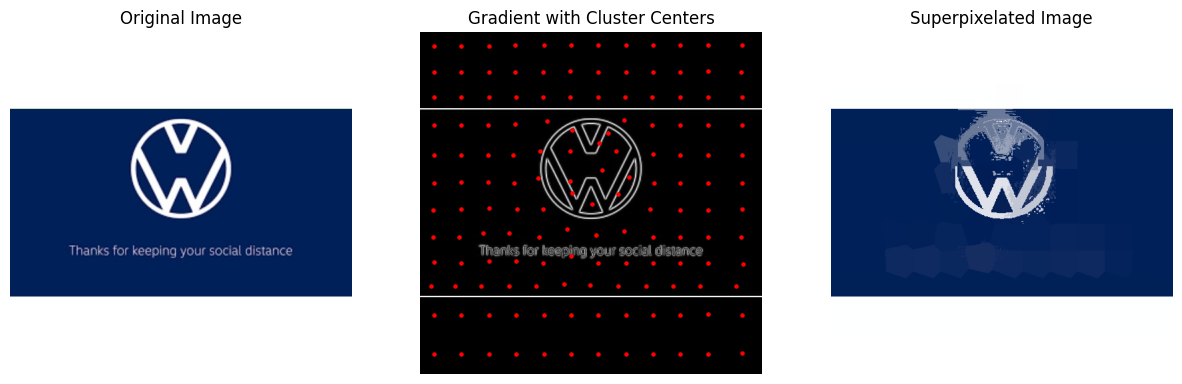

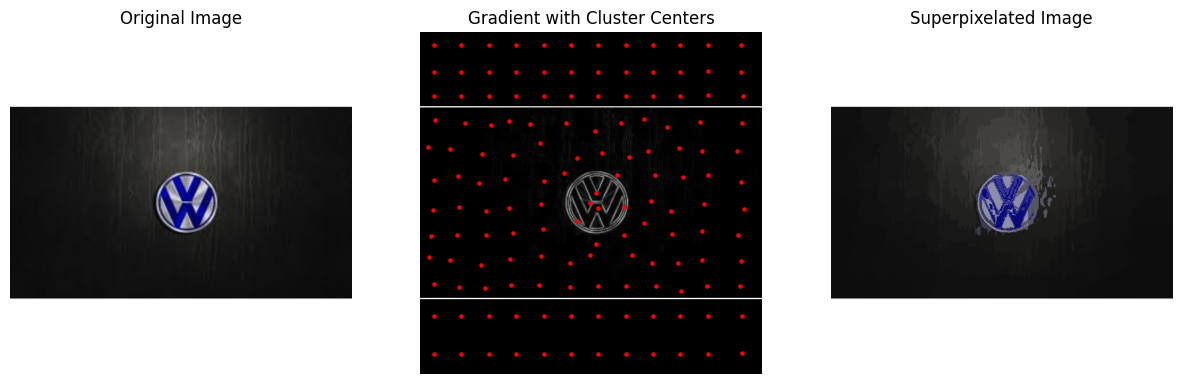

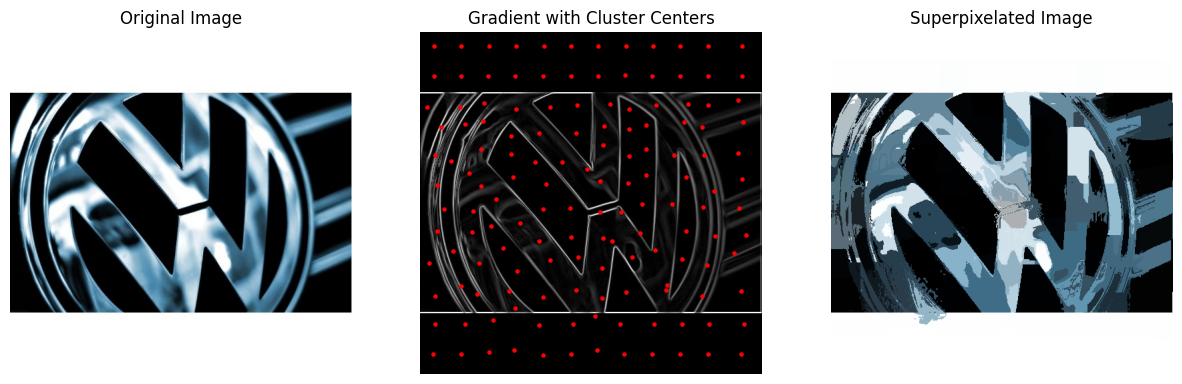

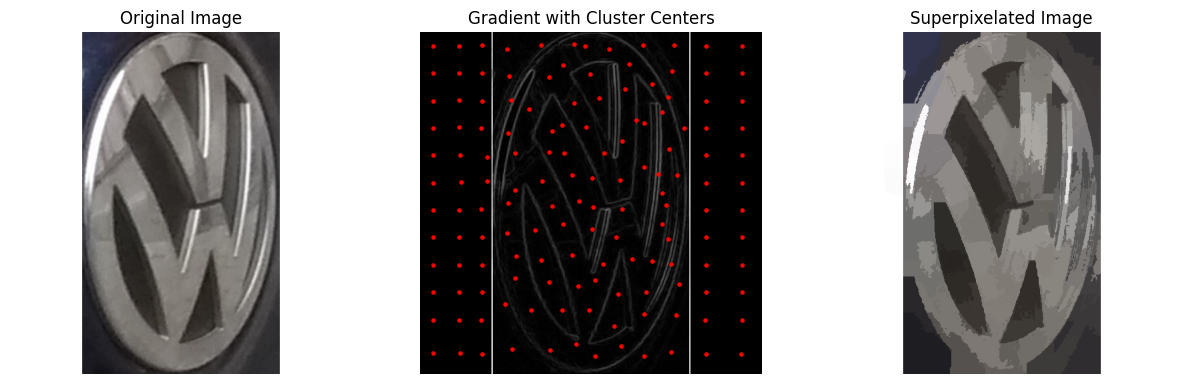

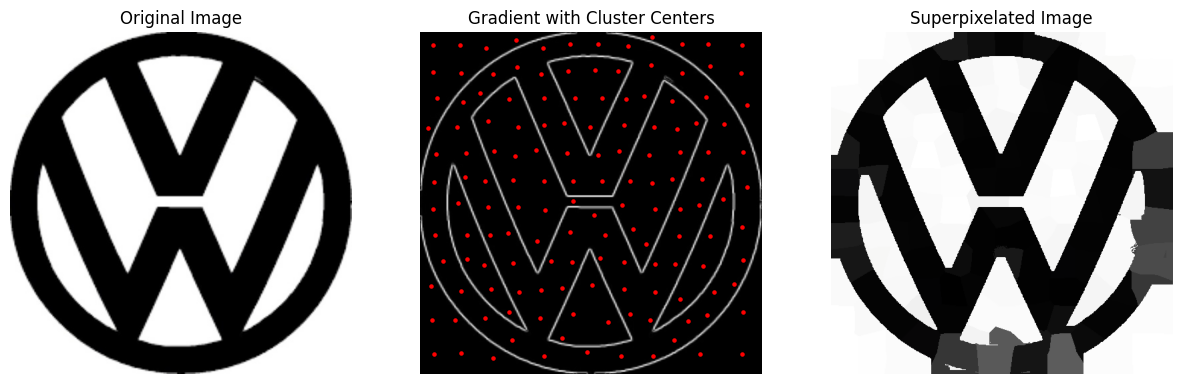

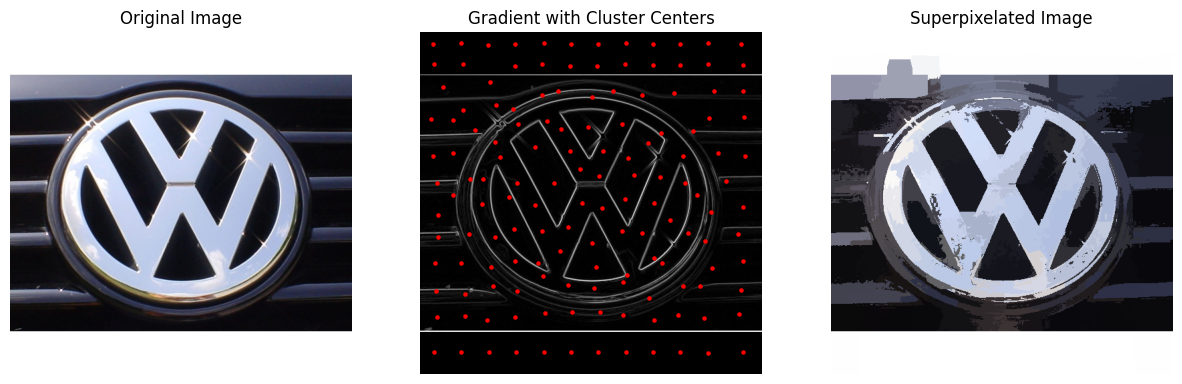

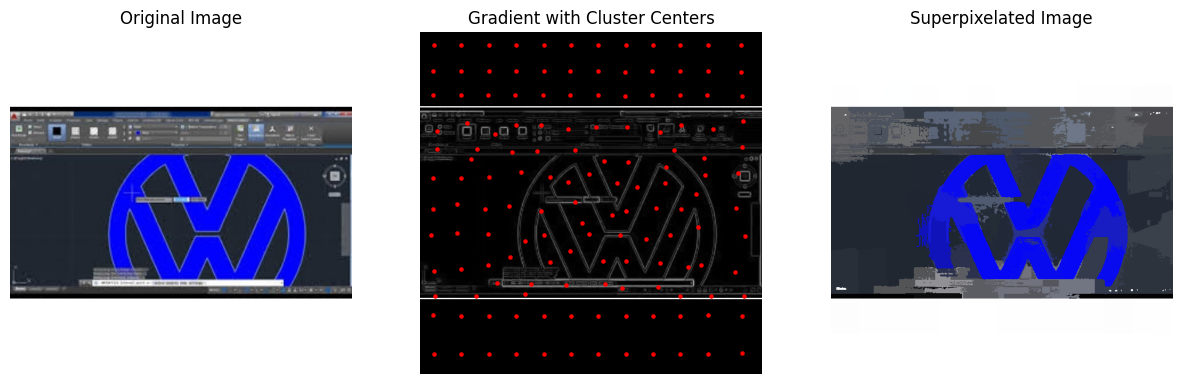

In [8]:
for root, dirs, files in os.walk(test_path):
    for file in np.random.choice(files, 10, replace=False):
        img_path = os.path.join(root, file)
        image = cv2.imread(img_path)
        if image is not None:  # Check if the image was correctly loaded
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            final_img, superpixels, cluster_centers_final, img_gradient = slic_superpixels(
                image, K=150, m=2)

            # Create a figure to hold the subplots
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

            # Display the original image on the left
            ax[0].imshow(image)
            ax[0].set_title("Original Image")
            ax[0].axis('off')

            # Display the gradient image with final cluster centers in the middle
            # Assuming img_gradient is a grayscale image
            ax[1].imshow(img_gradient, cmap='gray')
            ax[1].scatter([y for x, y in cluster_centers_final], [
                          x for x, y in cluster_centers_final], color='red', s=5)  # Plotting the cluster centers
            ax[1].set_title("Gradient with Cluster Centers")
            ax[1].axis('off')

            # Display the superpixelated image on the right
            ax[2].imshow(final_img)
            ax[2].set_title("Superpixelated Image")
            ax[2].axis('off')

            plt.show()
        else:
            print(f"Failed to load image: {img_path}")
